# **Modelagem preços de ações com Redes Neurais Recorrentes - LSTM**

Nesse pequeno projeto iremos aplicar uma rede neural artificial para modelar e gerar previsões com séries temporais. A rede neural que usaremos se chama LSTM (ou *Long short-term memory*) e é uma rede neural recorrente, ou seja, ela é uma estrutura de processamento que consegue representar grandes variedades de comportamentos dinâmicos. 

As redes neurais recorrentes possuem mecanismos de *loops*, permitindo que haja realimentação de informação e a criação de representações internas e mecanismos de **memória** que permitem armazenar infomações temporais (principalmente de séries temporais). O fato de possuir muitos *loops*, mesmo com um número reduzido de parâmetros, a rede neural pode gerar um comportamento complexo.

A maioria das redes neurais recorrentes possuem problemas de dependência de longo prazo. Problema de denpendência de longo prazo é quando uma rede neural precisa de um contexto maior (mais informações anteriores à atual) para poder gerar uma previsão acurada. As LSTM's não possuem esse problema, pois foram projetadas para evitar esse problema de dependência.

A LSTM é bastante usada para previsões de séries temporais e usaremos ela aqui para modelar dados de preços de ações.

## Dados

Os dados foram extraídos da plataforma *Yahoo* e são os preços das ações da Petróleo Brasileiro S/A (Petrobras) na Bolsa de valores americana. A peoridicidade é diária e vai do dia 1 de janeiro de 2014 até 31 de março de 2020. Aqui, iremos modelar os preços de fechamento das ações *PBR*.




## Importação das bibliotecas

In [8]:
import pandas_datareader as web
import math
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')


## Importa dos dados

Vamos usar o *DataReader* para extrair os dados da platadforma *Yahoo* com a periodicidade e intervalo que queremos.

In [9]:
df=web.DataReader('PBR', data_source='yahoo',start='2014-01-01',end='2020-03-31')

## Análise Exploratória dos dados

Podemos ver as 5 primeiras observações dos 5 preços que foram extraídos (de alta, de baixa, de abertura, de fechamento e o de fechamento ajustado) e o volume de ações que foram negociadas no dia.

In [10]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,13.50,13.20,13.45,13.32,18218000.0,12.239623
2014-01-03,13.37,13.00,13.26,13.12,19993700.0,12.055844
2014-01-06,13.20,12.89,12.97,13.16,12475200.0,12.092600
2014-01-07,13.38,12.82,13.38,12.90,19305300.0,11.853689
2014-01-08,12.96,12.66,12.93,12.68,17711000.0,11.651535


Temos 1572 observações no nosso conjunto de dados.

In [11]:
df.shape

(1572, 6)

A colunas não possuem nenhum valor faltante.

In [12]:
df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Todos os dados são do tipo *float*.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1572 entries, 2014-01-02 to 2020-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1572 non-null   float64
 1   Low        1572 non-null   float64
 2   Open       1572 non-null   float64
 3   Close      1572 non-null   float64
 4   Volume     1572 non-null   float64
 5   Adj Close  1572 non-null   float64
dtypes: float64(6)
memory usage: 86.0 KB


Abaixo podemos ver a tabela estatística de todas as variáveis.

In [14]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1572.000000,1572.000000,1572.000000,1572.000000,1.572000e+03,1572.000000
mean,11.124447,10.741272,10.939198,10.930000,2.590220e+07,10.418804
std,3.810902,3.749890,3.784357,3.781226,1.575718e+07,3.641767
min,2.970000,2.710000,2.880000,2.900000,2.875700e+06,2.753971
25%,8.525000,8.280000,8.400000,8.405000,1.557595e+07,7.981766
50%,10.810000,10.440000,10.620000,10.625000,2.232935e+07,10.072659
75%,14.580000,14.230000,14.430000,14.400000,3.099108e+07,13.838701
max,20.940001,19.959999,20.830000,20.650000,1.810443e+08,19.610168


Visualizando as séries de preços e volume de ações.

In [15]:
df.corr()

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.998618,0.999002,0.998988,-0.247111,0.998319
Low,0.998618,1.000000,0.998739,0.999099,-0.280662,0.998620
Open,0.999002,0.998739,1.000000,0.997760,-0.261973,0.997191
Close,0.998988,0.999099,0.997760,1.000000,-0.264658,0.999412
Volume,-0.247111,-0.280662,-0.261973,-0.264658,1.000000,-0.265832
Adj Close,0.998319,0.998620,0.997191,0.999412,-0.265832,1.000000


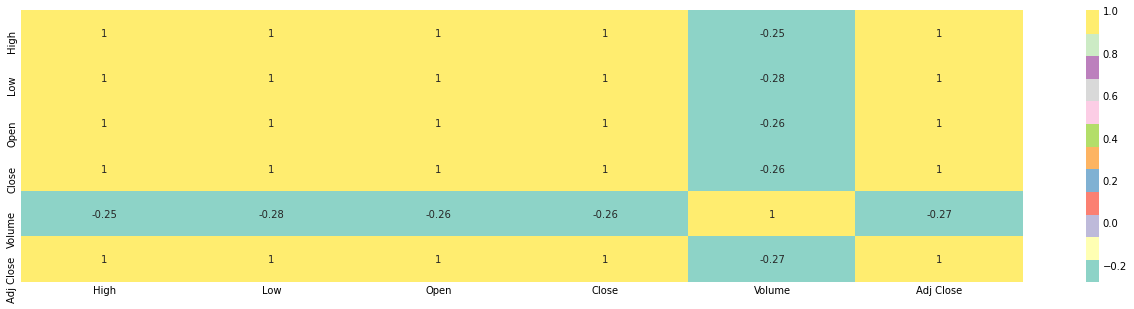

In [16]:
%matplotlib inline
plt.figure(figsize=(20,5))
correlacao=df.corr()
sns.heatmap(correlacao, annot = True, cmap = "Set3");

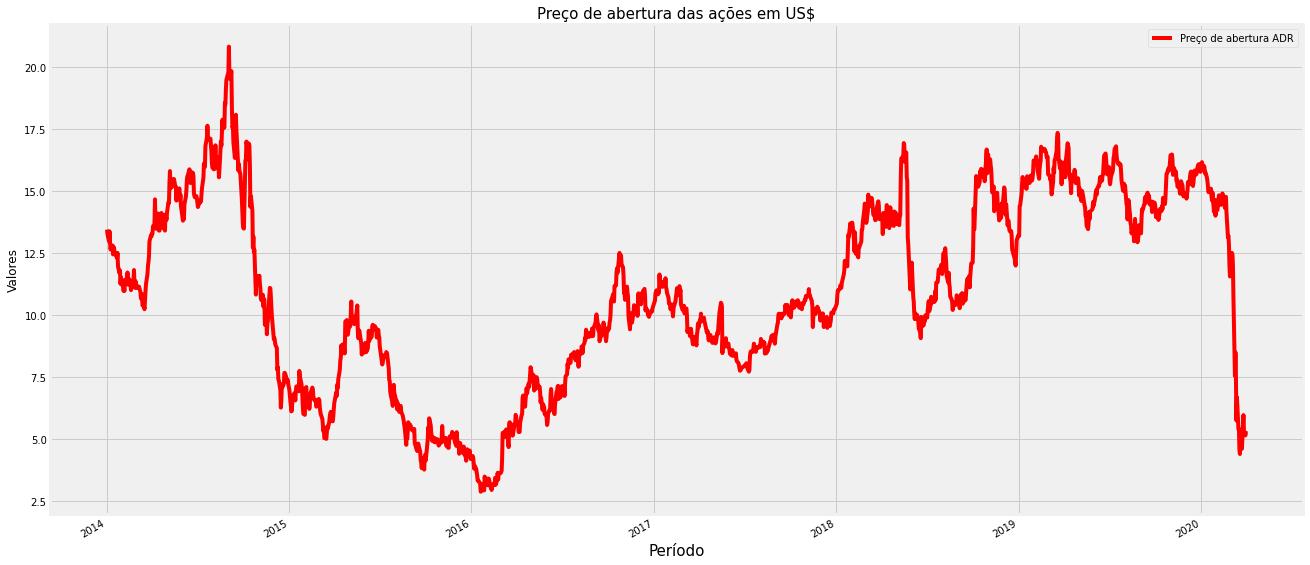

In [17]:
plt.figure(figsize=(20,10))
df['Open'].plot(color='red')
plt.title('Preço de abertura das ações em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de abertura ADR'])
plt.show()

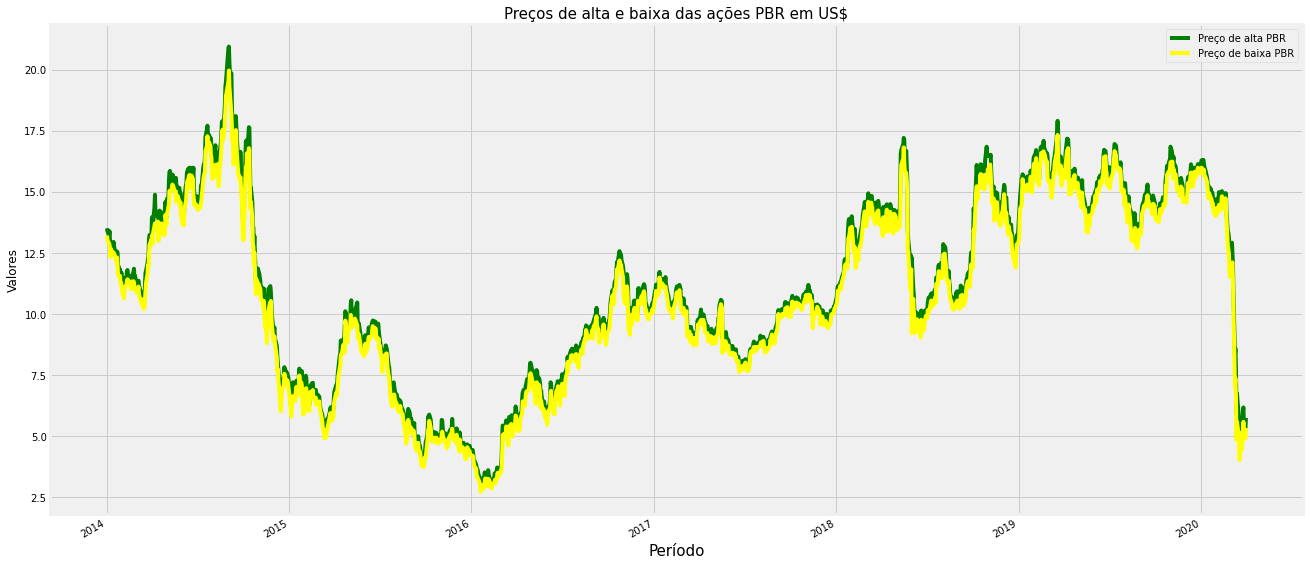

In [18]:
plt.figure(figsize=(20,10))
df['High'].plot(color='green')
df['Low'].plot(color='yellow')
plt.title('Preços de alta e baixa das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de alta PBR','Preço de baixa PBR'])
plt.show()

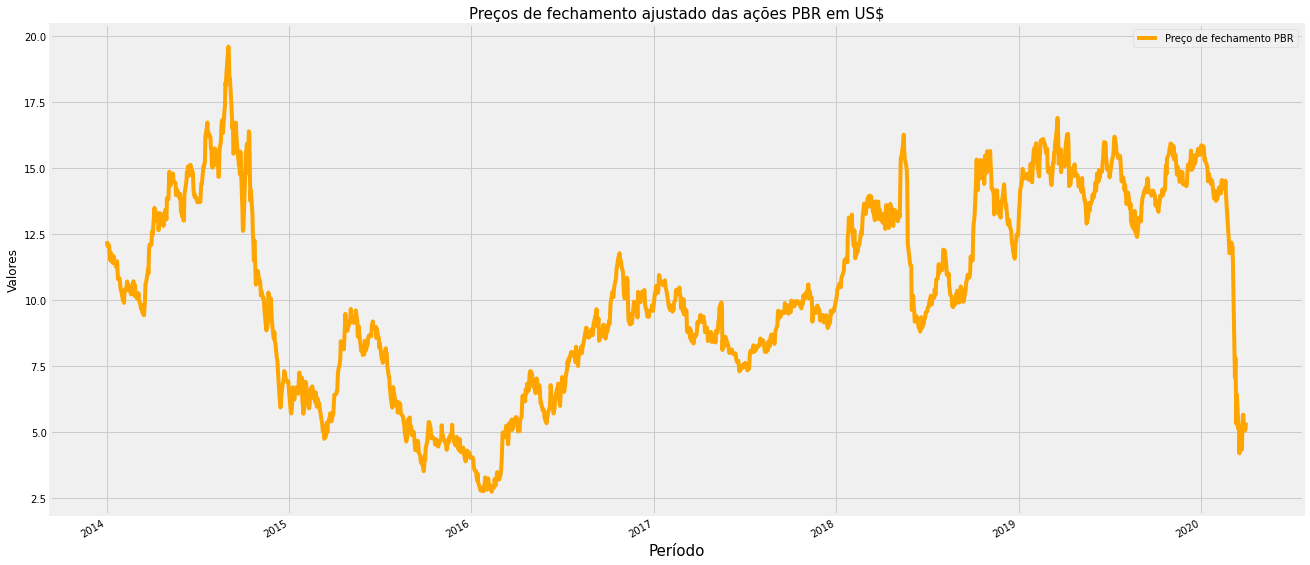

In [19]:
plt.figure(figsize=(20,10))
df['Adj Close'].plot(color='orange')
plt.title('Preços de fechamento ajustado das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

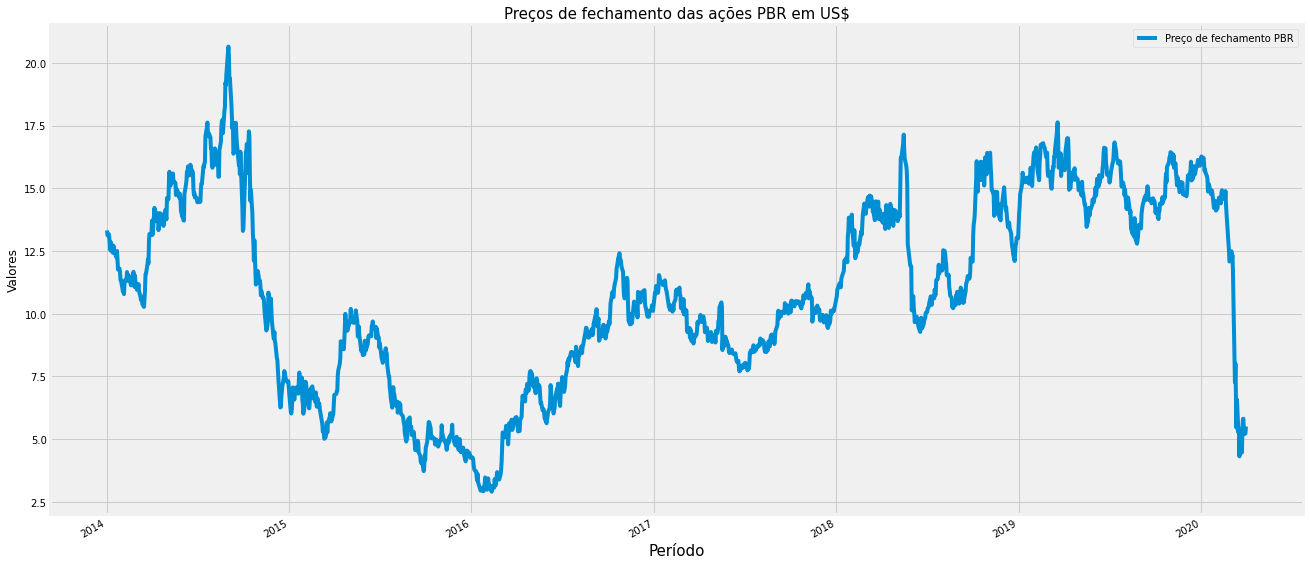

In [20]:
plt.figure(figsize=(20,10))
df['Close'].plot()
plt.title('Preços de fechamento das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

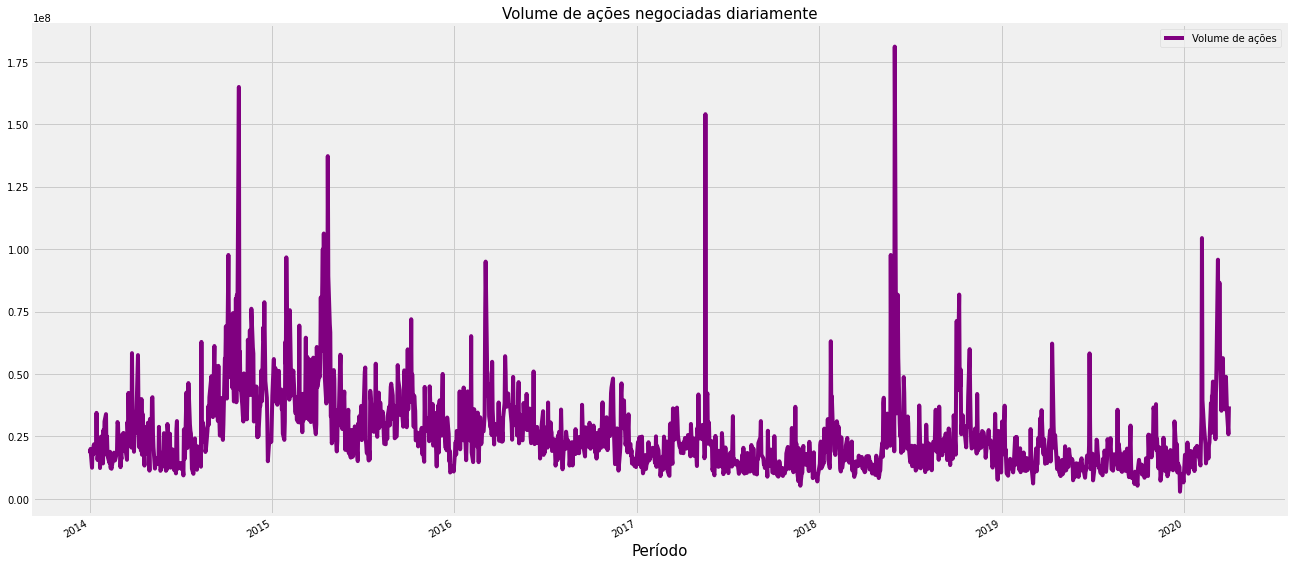

In [21]:
plt.figure(figsize=(20,10))
df['Volume'].plot(color='purple')
plt.title('Volume de ações negociadas diariamente', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('')
plt.legend(['Volume de ações'])
plt.show()

## Dados de treino

Vamos agora separar os dados de treino. Vamos escolher para os dados de treino 80% da série temporal. Para o treino teremos 1258 observações.

In [22]:
#Da série vamos extrair apenas os dados de fechamento
data=df.filter(['Close'])
#selecionar seus valores
dataset=data.values
#separa 80% desses dados
training_data_len=math.ceil(len(dataset)*.8)
#e vamos visualizar quantas observações temos
training_data_len

1258

## Transformação dos dados

Precisaremos alterar a escala dos dados para o futuro procedimento de treino e geração de previsões do modelo. Usaremos o método *MinMaxScaler* que colocará os dados em uma escala entre 0 e 1.

In [23]:
#escalando para o intervalo entre 0 e 1
scaler=MinMaxScaler(feature_range=(0,1))

#transformando os dados
scaled_data = scaler.fit_transform(dataset)

#dados transformados para a escala que escolhemos
scaled_data

array([[0.58704225],
       [0.57577465],
       [0.57802817],
       ...,
       [0.12901409],
       [0.13070421],
       [0.14647887]])

Agora vamos separar os dados em *x* e *y* de treino.

In [24]:
#criando um dataset de treino
train_data = scaled_data[0:training_data_len,:]
#separando dados de treino e teste
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()

[array([0.58704225, 0.57577465, 0.57802817, 0.56338027, 0.55098594,
       0.54197187, 0.56000002, 0.53859156, 0.53633804, 0.55267607,
       0.5430986 , 0.53971829, 0.52619718, 0.54084508, 0.52169014,
       0.49915495, 0.50140847, 0.49352113, 0.47549297, 0.47549297,
       0.46816902, 0.44901408, 0.45802816, 0.44394365, 0.46873242,
       0.47549297, 0.47323945, 0.49352113, 0.48225353, 0.48788736,
       0.48507044, 0.46760563, 0.46366199, 0.47211267, 0.48056341,
       0.49408452, 0.47492958, 0.46028168, 0.48563384, 0.46760563,
       0.45352112, 0.46140847, 0.45746482, 0.4664789 , 0.45070421,
       0.43830988, 0.43042254, 0.43887322, 0.43042254, 0.42084507,
       0.4152113 , 0.43154933, 0.45070421, 0.48845069, 0.48957748,
       0.51098594, 0.52225353, 0.51267606, 0.56450706, 0.57915496])]
[0.5774647773813806]

[array([0.58704225, 0.57577465, 0.57802817, 0.56338027, 0.55098594,
       0.54197187, 0.56000002, 0.53859156, 0.53633804, 0.55267607,
       0.5430986 , 0.53971829, 0.526

Vamos converter *x_train* e *y_train* para *array numpy*.

In [25]:
x_train,y_train = np.array(x_train), np.array(y_train)

Em *x_train* temos um *array* com dimensões 1198 x 60.

In [26]:
x_train.shape

(1198, 60)

Agora vamos redimensionar os dados.

In [27]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1198, 60, 1)

## Modelagem dos dados

Agora vamos criar o nosso modelo. Como é uma rede neural teremos camadas de entradas, camadas intermediárias e camadas de saída. Temos o nosso modelo *Sequential* e vamos adicionando as camadas (*LSTM* e *Dense*). As duas primeiras camadas possuem 50 neurônios, a penúltima camada densa (*Dense*) 25 e a última camada tem apenas 1 neurônio que é de onde serão geradas as saídas do modelo, que serão as nossas previsões.

In [28]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


Agora que o nosso modelo foi criado, podemos configurá-lo com a função perda e com as métricas. Aqui usaremos o *adam* que é o método *stochastic gradient descent* ou gradiente estocástico descendente que é um dos métodos de minimização. A métrica de avaliação que usaremos será o *mean_squared_error* ou média dos erros quadrados.

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')

Vamos treinar o modelo e usaremos um período de treino ou *epoch*.

In [30]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1198/1198 [==============================] - 26s 22ms/step - loss: 0.0035


## Dados de teste

Aqui vamos criar dois conjuntos de dados de teste *x_test* e *y_test*, uma para aplicar ao modelo treinado e o outro para comparar o resultados das previsões. Faremos, praticamente, a mesma coisa que na seleção dos dados de treino. Vamos separar os dados, mas apenas ao *x_test* transformaremos em um *array numpy*.

In [31]:
#criando os dados de teste
test_data=scaled_data[training_data_len-60:,:]

#criando x_test e y_test
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

Convertendo em um *array numpy*.

In [32]:
x_test=np.array(x_test)

Redimensionando os dados de teste que serão aplicado no modelo para previsão.

In [33]:
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Gerando as previsões com o modelo LSTM e logo em seguida iremos inverter a transformação que fizemos para que os resultados tenham a escala correta.

In [34]:
predictions=model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## Avaliação do modelo

Agora teremos que avaliar o desempenho do modelo comparando com os valores reais, para isso usaremos a métrica *RMSE* (*root mean squared error* ) que nos trará a raiz da média do quadrado dos erros. Essa métrica é a mais usada para avaliar modelos de séries temporais.

O nosso resultado de um valor menor que 1. Em alguns trabalhos, para avaliar o desempenho do modelo, comparamos o resultado do *RMSE* com o desvio padrão. No nosso caso o desvio padrão da série de preços de fechamento foi de 3.78 e nosso *RMSE* de 0.72. Logo temos um bom resultado gerado pelo modelo.

In [35]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.7232485303453579

Vamos uma coluna com os dados de validação e as previsões e comparar os resultados.

In [36]:
train=data[:training_data_len]

valid=data[training_data_len:]

valid['Predictions'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Avaliando graficamente, vemos que o resultado das previsões foi muito próximo, para não dizer quase idêntico.

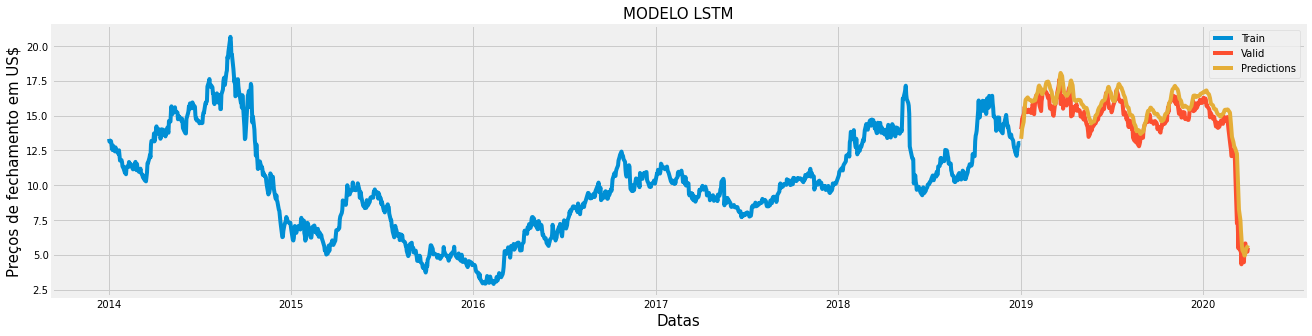

In [37]:
plt.figure(figsize=(20,5))
plt.title('MODELO LSTM',size=15)
plt.xlabel('Datas',size=15)
plt.ylabel('Preços de fechamento em US$',size=15)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'])
plt.show()

Podemos comparar as médias dos valores de validação e das previsões. Vemos que as médias são bem próximas uma das outras.

In [45]:
print('Média dos valores reais:',valid['Close'].mean())
print('Média das previsões da LSTM:',valid['Predictions'].mean())

Média dos valores reais: 14.605668758890431
Média das previsões da LSTM: 15.328908920288086


Abaixo podemos ver as estatísticas descritivas completas das previsões e dos dados de validação. As médias, desvios-pradrão e quantis possuem os valores próximos.

In [47]:
valid.describe()

,Close,Predictions
count,314.000000,314.000000
mean,14.605669,15.328909
std,2.382819,2.280091
min,4.310000,4.936971
25%,14.400000,15.036557
50%,15.145000,15.836008
75%,15.857500,16.504201
max,17.629999,18.057217


## Conclusão

Esse pequeno projeto vimos as etapas para o tratamento e modeloagem de dados com essa poderosa rede neural recorrente chamada LSTM. A LSTM possui uma capacidade formidável de gerar resultados acurados, pelo seu mecanismo de memória de longo prazo; resultados esses que podem até ter um desempenho melhor do que outros métodos de modelagem de séries temporais (como algoritmos determinísticos ou a modelagem Box-Jenkins).